# 石炭、原油、石油ガス、液化天然ガス、金の相場、銀の相場、プラチナの相場と為替変動に関する重要な特性を可視化する
---
## 探索的データ解析
- 散布図行列の作成
- データの分布と外れ値が含まれているか調べる。

In [83]:
import pandas as pd
df = pd.read_csv('./dataset/dataset.csv')
df.columns = ['coal', 'crude oil', 'coal gas', 'liquefied natural gas','yen_gold_av','yen_platinum_av','yen_silver_av','exchange rate after a month']
df.head()

,coal,crude oil,coal gas,liquefied natural gas,yen_gold_av,yen_platinum_av,yen_silver_av,exchange rate after a month
0,-0.020279,-0.163987,-0.009600,0.006485,0.022417,0.065256,0.057923,-0.009034
1,0.020536,-0.007016,0.000636,-0.006106,-0.021926,-0.042219,-0.037190,0.043839
2,0.066874,0.050738,0.042403,0.027418,0.038012,0.013397,0.008047,0.022318
3,0.079307,0.042530,0.010837,0.021257,0.012207,0.042217,0.017030,-0.015324
4,0.005649,0.000284,-0.057594,-0.025932,0.030612,0.007774,-0.000523,0.001832


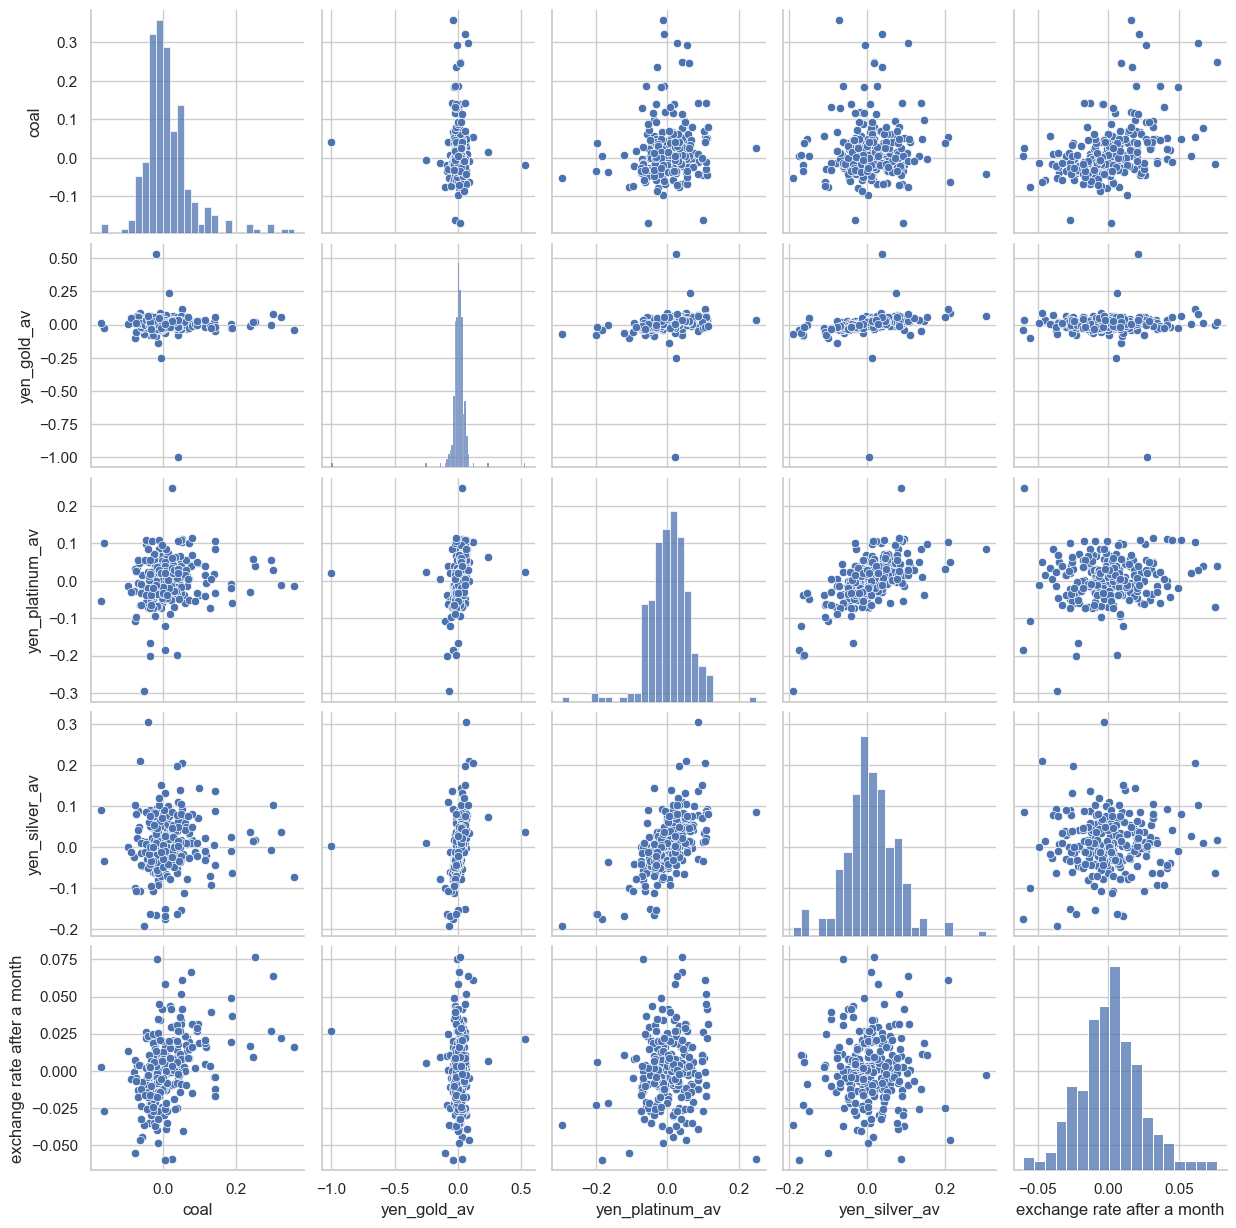

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid',context='notebook')
cols = ['coal', 'yen_gold_av', 'yen_platinum_av', 'yen_silver_av', 'exchange rate after a month']
sns.pairplot(df[cols], height=2.5)
plt.show()

# ピアソンの積率相関係数
## 共分散


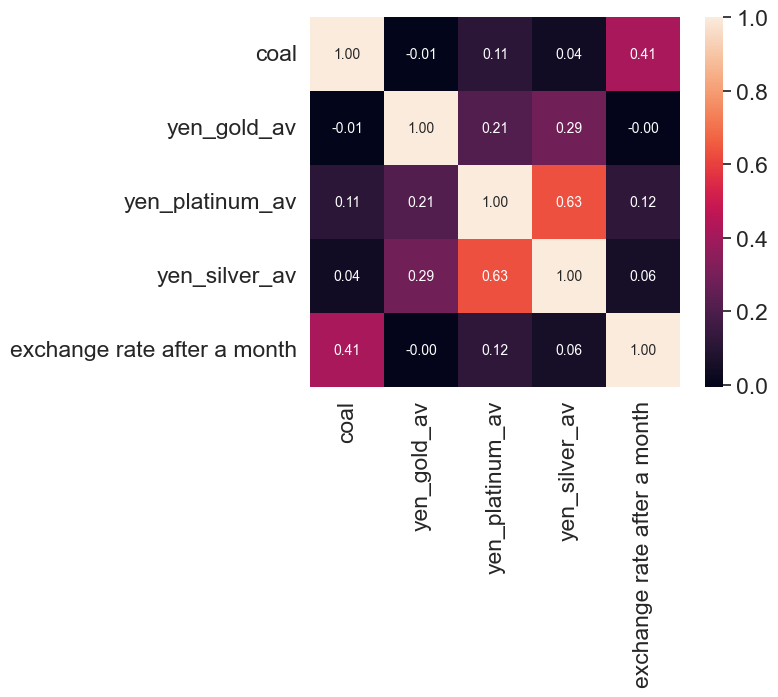

In [13]:
import numpy as np
cm = np.corrcoef(df[cols].values.T)
#sns.set(font_scale=1.5)
hm = sns.heatmap(cm,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 10},
                 yticklabels=cols,
                 xticklabels=cols)
plt.show()

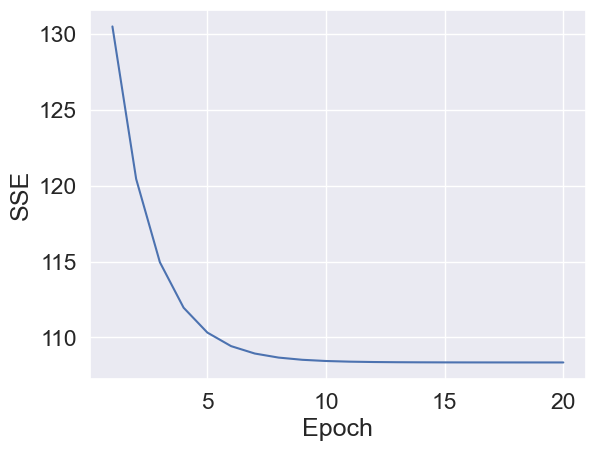

In [14]:
class LinearRegressionGD(object):
    def __init__(self,eta=0.001, n_iter=20):
        self.eta=eta
        self.n_iter=n_iter  

    def fit(self, X, y):
        self.w_ = np.zeros(1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        return self.net_input(X)
        
X = df[['coal']].values
y = df['exchange rate after a month'].values
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
sc_y = StandardScaler()

X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten()
# print(X_std)
# print(f'{len(y_std)}:{y_std}')
lr = LinearRegressionGD()
lr.fit(X_std,y_std)

plt.plot(range(1, lr.n_iter+1),lr.cost_)
plt.ylabel('SSE')
plt.xlabel('Epoch')
plt.show()

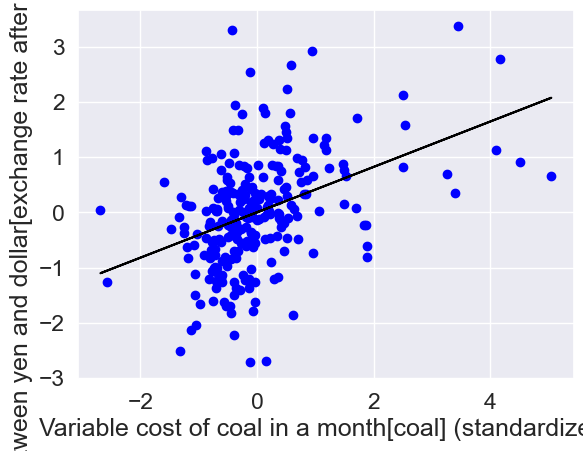

In [22]:
def lin_regplot(X,y,model):
    plt.scatter(X,y,c='blue')
    plt.plot(X, model.predict(X), color='black')


lin_regplot(X_std, y_std, lr)
plt.xlabel('Variable cost of coal in a month[coal] (standardized)')
plt.ylabel('Exchange rate between yen and dollar[exchange rate after amonth] (standardized)')
plt.show()

In [23]:
print('Slope: %.3f' % lr.w_[1])
print('Intercept: %.3f' % lr.w_[0])

Slope: 0.411
Intercept: -0.000


In [30]:
coalVC_std = sc_x.transform([[1]])
exchangeRate_std = lr.predict(coalVC_std).reshape(-1,1)
print("up 1percecnt of coal price rate: %.3f" % sc_y.inverse_transform(exchangeRate_std))


up 1percecnt of coal price rate: 0.135


# sickit-learnを用いた回帰モデルの係数の推定
- LinearRegression()を用いる.

In [31]:
from sklearn.linear_model import LinearRegression
slr = LinearRegression()
slr.fit(X, y)
y_pred = slr.predict(X)
print('Slope: %.3f' % slr.coef_[0])
print('Intercept: %.3f' % slr.intercept_)

Slope: 0.136
Intercept: -0.001


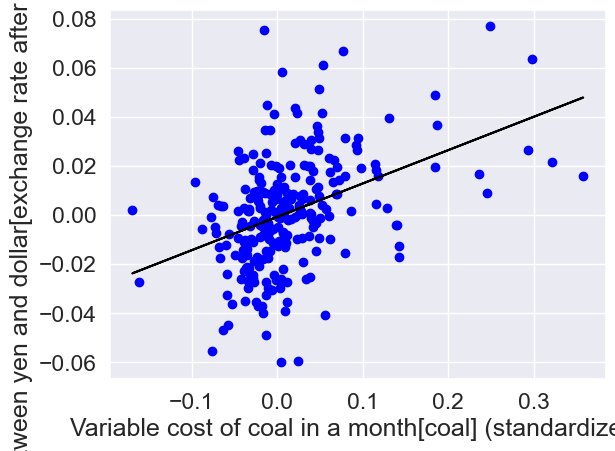

In [33]:
lin_regplot(X, y, slr)
plt.xlabel('Variable cost of coal in a month[coal] (standardized)')
plt.ylabel('Exchange rate between yen and dollar[exchange rate after amonth] (standardized)')
plt.show()

# RANSACを用いたロバスト回帰モデルの学習
1. 正常値としてランダムな数のサンプルを選択し、モデルを学習させる.
2. 学習済みのモデルに対し、その他すべてのデータ点を評価し、ユーザー指定の許容範囲となるデータ点を正常値に追加する.
3. 全ての正常値を用いてモデルを再学習させる.
4. 正常値に対する学習済みのモデルの誤差を推定する.
5. モデルの性能がユーザ指定の閾値の条件を満たしている場合、またはイテレーションが規定の回数に達した場合はアルゴリズムを終了する.そうでなければステップ1に戻る.

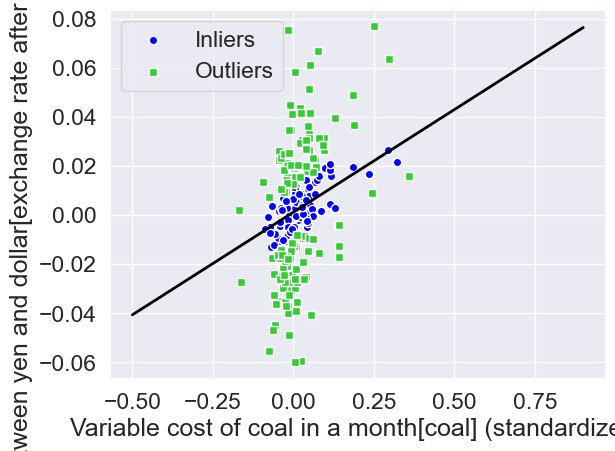

In [35]:
from sklearn.linear_model import RANSACRegressor

ransac = RANSACRegressor(LinearRegression(), 
                         max_trials=100, 
                         min_samples=50, 
                         loss='absolute_error',  
                         residual_threshold=0.01, 
                         random_state=0)


ransac.fit(X, y)

inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask) 

line_X = np.arange(-0.5, 1.0, 0.1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])
plt.scatter(X[inlier_mask], y[inlier_mask],
            c='blue', edgecolor='white', 
            marker='o', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask],
            c='limegreen', edgecolor='white', 
            marker='s', label='Outliers')
plt.plot(line_X, line_y_ransac, color='black', lw=2)   
plt.xlabel('Variable cost of coal in a month[coal] (standardized)')
plt.ylabel('Exchange rate between yen and dollar[exchange rate after amonth] (standardized)')
plt.legend(loc='upper left')

#plt.savefig('images/10_08.png', dpi=300)
plt.show()

In [36]:
print('Slope: %.3f' % ransac.estimator_.coef_[0])
print('Intercept: %.3f' % ransac.estimator_.intercept_)

Slope: 0.084
Intercept: 0.001


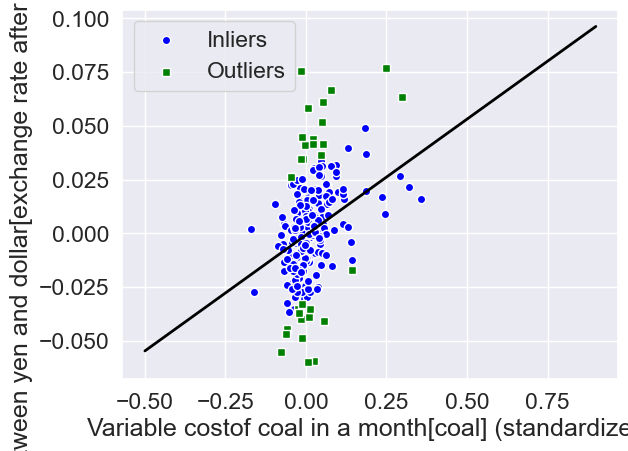

In [38]:
from sklearn.linear_model import RANSACRegressor

ransac = RANSACRegressor(LinearRegression(), 
                         max_trials=100, 
                         min_samples=50, 
                         loss='absolute_error',  
                         residual_threshold=0.03, 
                         random_state=0)


ransac.fit(X, y)

inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask) 

line_X = np.arange(-0.5, 1.0, 0.1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])
plt.scatter(X[inlier_mask], y[inlier_mask],
            c='blue', edgecolor='white', 
            marker='o', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask],
            c='green', edgecolor='white', 
            marker='s', label='Outliers')
plt.plot(line_X, line_y_ransac, color='black', lw=2)   
plt.xlabel('Variable costof coal in a month[coal] (standardized)')
plt.ylabel('Exchange rate between yen and dollar[exchange rate after amonth] (standardized)')
plt.legend(loc='upper left')

#plt.savefig('images/10_08.png', dpi=300)
plt.show()

In [39]:
print('Slope: %.3f' % ransac.estimator_.coef_[0])
print('Intercept: %.3f' % ransac.estimator_.intercept_)

Slope: 0.108
Intercept: -0.001


# 線形回帰のモデル評価

In [40]:
from sklearn.model_selection import train_test_split

X = df.iloc[:, :-1].values
y = df['exchange rate after a month'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

slr = LinearRegression()

slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

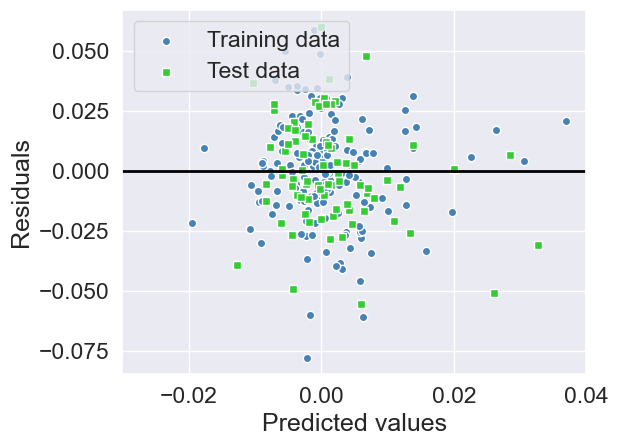

In [41]:
plt.scatter(y_train_pred,  y_train_pred - y_train,
            c='steelblue', marker='o', edgecolor='white',
            label='Training data')
plt.scatter(y_test_pred,  y_test_pred - y_test,
            c='limegreen', marker='s', edgecolor='white',
            label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-0.03, xmax=0.04, color='black', lw=2)
plt.xlim([-0.03, 0.04])
plt.tight_layout()

# plt.savefig('images/10_09.png', dpi=300)
plt.show()



In [42]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

MSE train: 0.000, test: 0.000
R^2 train: 0.110, test: 0.233


# 回帰に正則化手法を使用

In [43]:
# リッジ回帰モデル---正則化の強さをalphaパラメタで指定
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=1.0)


# LASSO回帰モデル---正則化の強さをalphaパラメタで指定
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=1.0)


# Elastic Netモデル---l1_ratioによりL1ペナルティとL2ペナルティの比率を指定
from sklearn.linear_model import ElasticNet
elanet = ElasticNet(alpha=1.0, l1_ratio=0.5)

# 多項式回帰:線形回帰モデルから曲線を見出す

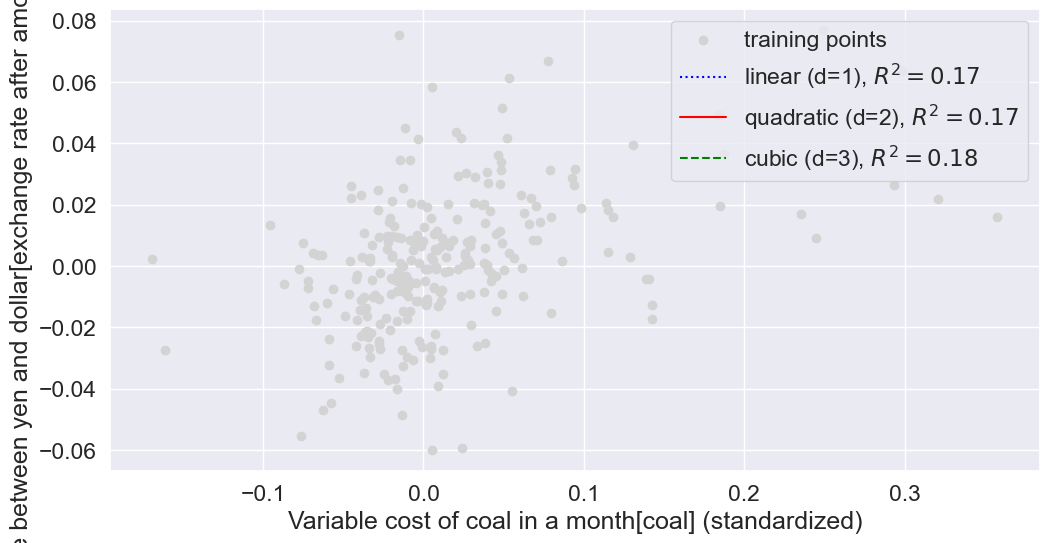

In [66]:
from sklearn.preprocessing import PolynomialFeatures
X = df[['coal']].values
y = df['exchange rate after a month'].values

regr = LinearRegression()

# create quadratic features
quadratic = PolynomialFeatures(degree=2)
cubic = PolynomialFeatures(degree=3)
X_quad = quadratic.fit_transform(X)
X_cubic = cubic.fit_transform(X)

# fit features
X_fit = np.arange(X.min(), X.max(), 1)[:, np.newaxis]

regr = regr.fit(X, y)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y, regr.predict(X))

regr = regr.fit(X_quad, y)
y_quad_fit = regr.predict(quadratic.fit_transform(X_fit))
quadratic_r2 = r2_score(y, regr.predict(X_quad))

regr = regr.fit(X_cubic, y)
y_cubic_fit = regr.predict(cubic.fit_transform(X_fit))
cubic_r2 = r2_score(y, regr.predict(X_cubic))


plt.figure(figsize=(12,6))
# plot results
plt.scatter(X, y, label='training points', color='lightgray')

plt.plot(X_fit, y_lin_fit, 
         label='linear (d=1), $R^2=%.2f$' % linear_r2, 
         color='blue', 
         linestyle=':')

plt.plot(X_fit, y_quad_fit, 
         label='quadratic (d=2), $R^2=%.2f$' % quadratic_r2,
         color='red', 
         linestyle='-')

plt.plot(X_fit, y_cubic_fit, 
         label='cubic (d=3), $R^2=%.2f$' % cubic_r2,
         color='green', 
         linestyle='--')

plt.xlabel('Variable cost of coal in a month[coal] (standardized)')
plt.ylabel('Exchange rate between yen and dollar[exchange rate after amonth] (standardized)')
plt.legend(loc='upper right')

#plt.savefig('images/10_11.png', dpi=300)
plt.show()

In [51]:
print('Training R^2 linear:%.3f quadratic: %.3f cubic: %.3f' % (linear_r2, quadratic_r2, cubic_r2))

Training R^2 linear:0.170 quadratic: 0.174 cubic: 0.183


In [74]:
X = df[['coal']].values
y = df['exchange rate after a month'].values

# transform features
X_log = np.log(X)
y_log = np.log(y)

# fit features
X_fit = np.arange(X_log.min()-0.000001, X_log.max()+0.000001, 0.000001)[:, np.newaxis]

regr = regr.fit(X_log, y_log)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y_log, regr.predict(X_log))

# plot results
plt.scatter(X_log, y_log, label='training points', color='lightgray')

plt.plot(X_fit, y_lin_fit, 
         label='linear (d=1), $R^2=%.2f$' % linear_r2, 
         color='blue', 
         lw=2)

plt.xlabel('Variable cost　of coal in a month[coal] (standardized)')
plt.ylabel('Exchange rate between yen and dollar[exchange rate after amonth] (standardized)')
plt.legend(loc='lower left')

plt.tight_layout()
#plt.savefig('images/10_12.png', dpi=300)
plt.show()

C:\Users\naoya\AppData\Local\Temp\ipykernel_11692\1134132388.py:5: RuntimeWarning: invalid value encountered in log
  X_log = np.log(X)
C:\Users\naoya\AppData\Local\Temp\ipykernel_11692\1134132388.py:6: RuntimeWarning: invalid value encountered in log
  y_log = np.log(y)


ValueError: arange: cannot compute length

# ランダムフォレストを用いて非線形関係を扱う
- 決定木回帰
- ランダムフォレスト回帰

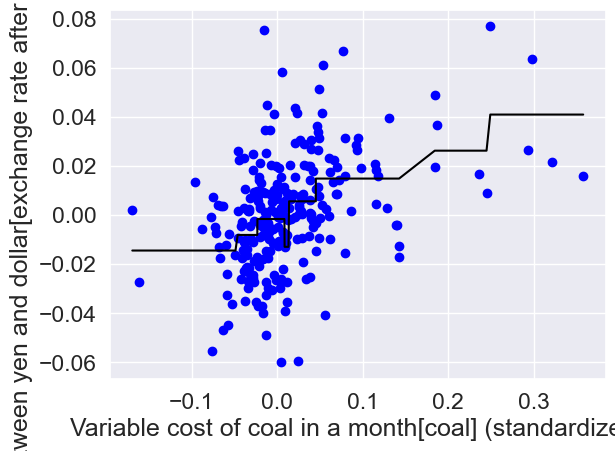

In [53]:
from sklearn.tree import DecisionTreeRegressor

X = df[['coal']].values
y = df['exchange rate after a month'].values

tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X, y)

sort_idx = X.flatten().argsort()

lin_regplot(X[sort_idx], y[sort_idx], tree)
plt.xlabel('Variable cost of coal in a month[coal] (standardized)')
plt.ylabel('Exchange rate between yen and dollar[exchange rate after amonth] (standardized)')
#plt.savefig('images/10_13.png', dpi=300)
plt.show()

In [54]:
X = df.iloc[:, :-1].values
y = df['exchange rate after a month'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=1)

In [61]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(n_estimators=1000, 
                               criterion='squared_error', 
                               random_state=1, 
                               n_jobs=-1)
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

MSE train: 0.000, test: 0.000
R^2 train: 0.853, test: 0.104


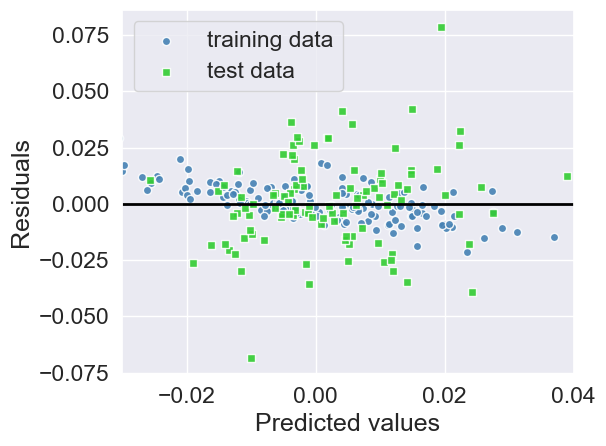

In [60]:
plt.scatter(y_train_pred,  
            y_train_pred - y_train, 
            c='steelblue',
            edgecolor='white',
            marker='o', 
            s=35,
            alpha=0.9,
            label='training data')
plt.scatter(y_test_pred,  
            y_test_pred - y_test, 
            c='limegreen',
            edgecolor='white',
            marker='s', 
            s=35,
            alpha=0.9,
            label='test data')

plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-0.03, xmax=0.04, color='black', lw=2)
plt.xlim([-0.03, 0.04])
plt.tight_layout()

# plt.savefig('images/10_14.png', dpi=300)
plt.show()

# 参考サイト

<a href='http://whitewell.sakura.ne.jp/AI/2019/Chapter10.html'>Python機械学習プログラミング-達人データサイエンティストによる理論と実践-

# 統計的分析2 
二か月後の為替とそのほかの石炭、原油・粗油、人口、貿易収支、一人当たりの国内総生産の関係性について分析する.

In [84]:
import pandas as pd
df1 = pd.read_csv('./dataset/dataset_other.csv')
df1.columns = ['coal', 'crude oil', "jinko", "boekishusi1Mb", "GDPperPerson1Mb", "exchange rate after two month"]
df1.head()

,coal,crude oil,jinko,boekishusi1Mb,GDPperPerson1Mb,exchange rate after two month
0,-0.020279,-0.163987,-0.000905,-0.127348,0.069904,0.043839
1,0.020536,-0.007016,0.001087,-0.127348,0.069904,0.022318
2,0.066874,0.050738,-0.000551,-0.127348,0.069904,-0.015324
3,0.079307,0.042530,0.000567,-0.127348,0.069904,0.001832
4,0.005649,0.000284,-0.000323,-0.127348,0.069904,0.020431


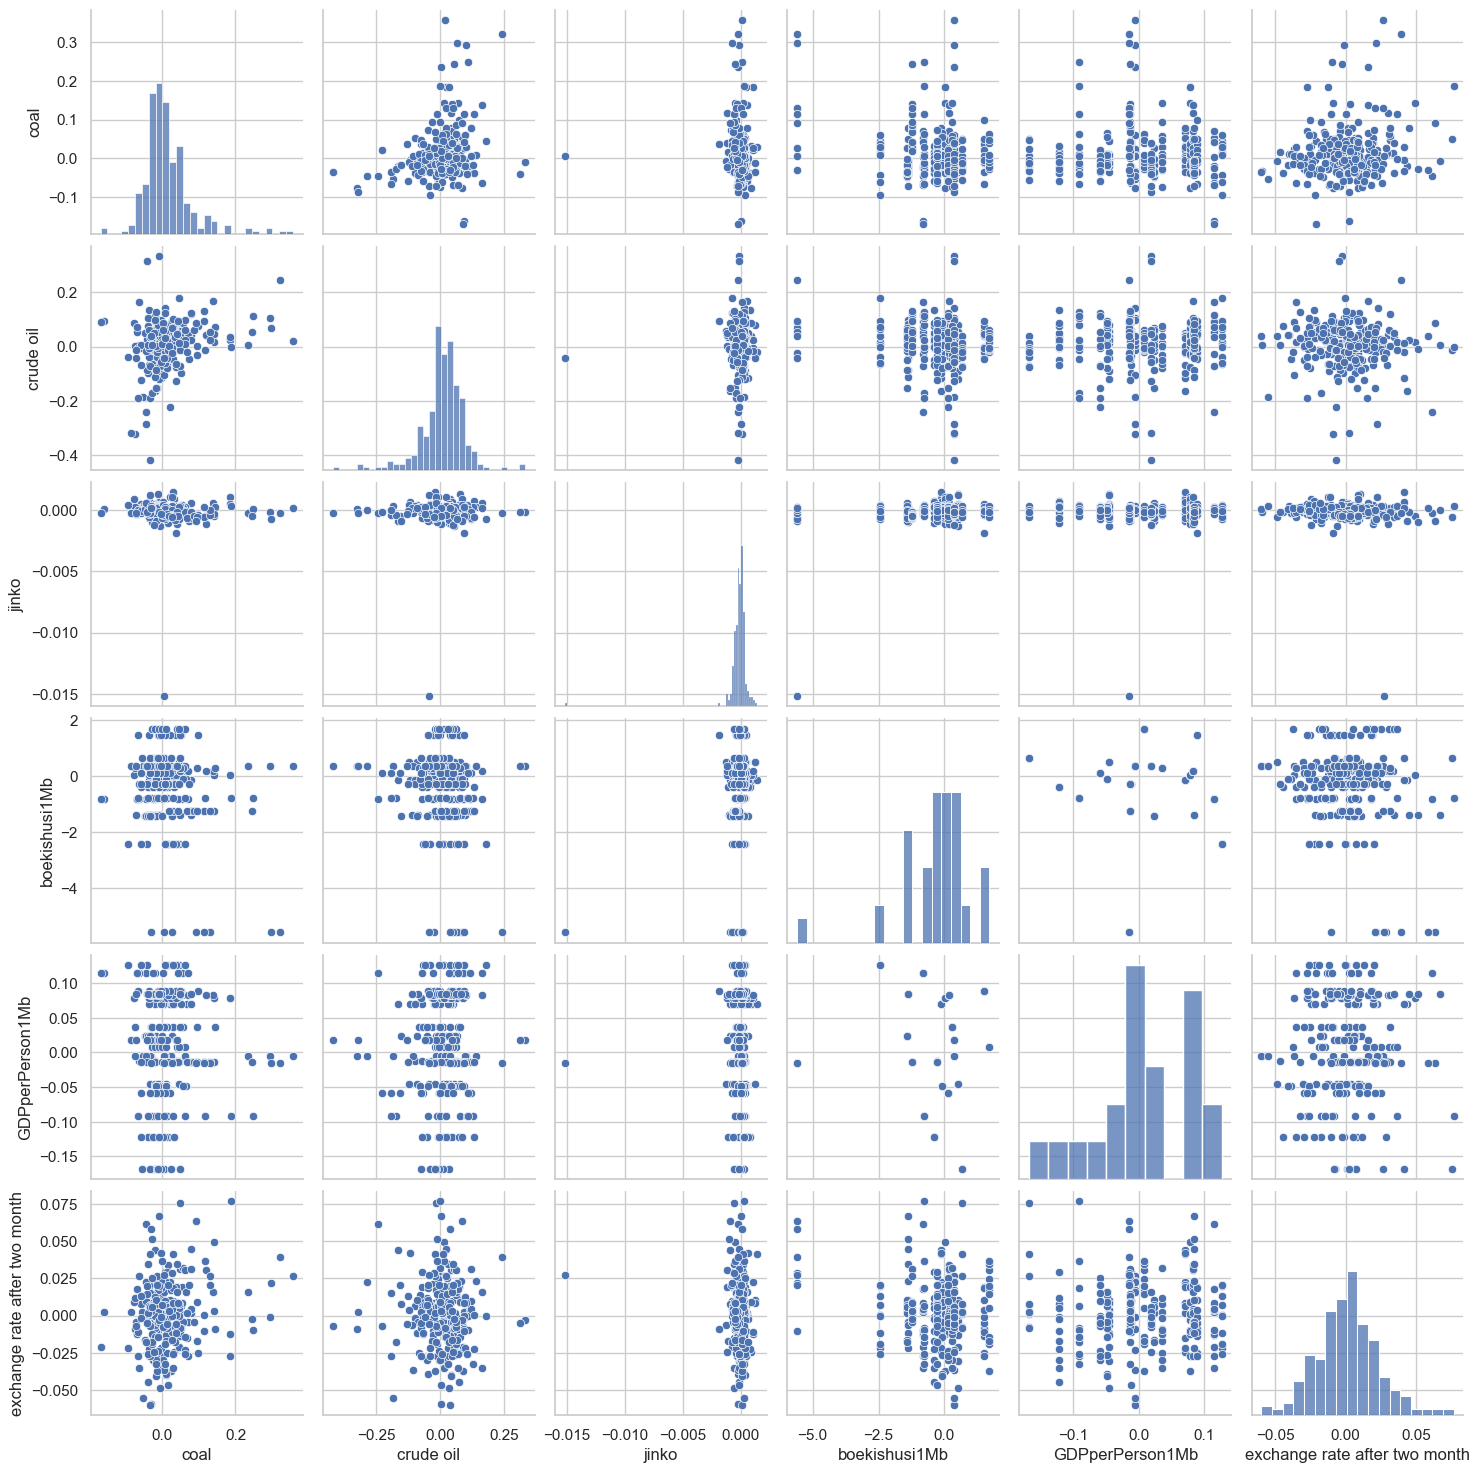

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid',context='notebook')
cols1 = ['coal', 'crude oil', 'jinko', 'boekishusi1Mb', 'GDPperPerson1Mb', 'exchange rate after two month']
sns.pairplot(df1[cols1], height=2.5)
plt.show()

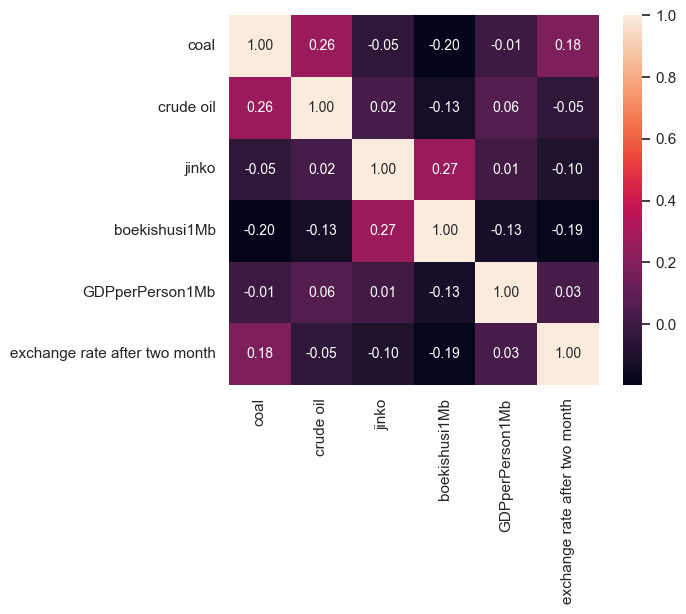

In [88]:
import numpy as np
cm = np.corrcoef(df1[cols1].values.T)
#sns.set(font_scale=1.5)
hm = sns.heatmap(cm,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 10},
                 yticklabels=cols1,
                 xticklabels=cols1)
plt.show()

# 結論
常に変化の絶えない為替などの値は回帰には向いていない.すなわち、連続値を予測することは難しい.であれば、二項分類に持ち込んで機械学習モデルを作成する.

# サポートベクトルマシンによるモデル作成

In [198]:
from sklearn import svm
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

data = pd.read_csv('./dataset/kawase_highlow2M.csv')
data.columns = ['coal', 'crude oil', "jinko", "boekishusi1Mb", "GDPperPerson1Mb", "kawase2Ma"]
# print(data.iloc[0:, [0,1,2,3,4]])

index = range(len(data))

# # 学習データとテストデータに分割
data_train, data_test, label_train, label_test, index_train, index_test = train_test_split(data.iloc[0:, [0,3]], data.iloc[0:, [-1]], index, test_size=0.3, random_state=0)
label_test = np.ravel(label_test)
label_train = np.ravel(label_train)


print("学習データの個数")
print(len(data_train))
print("テストデータの個数")
print(len(data_test))

# SVMの学習
#いじった場所
clf = svm.SVC(kernel="linear",gamma=10,C=10000)
clf.fit(data_train, label_train)

# テストデータに対する予測
predict_label = clf.predict(data_test)

学習データの個数
182
テストデータの個数
79


In [199]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics

# 予測結果の混同行列の出力
print(confusion_matrix(label_test, predict_label))

# 分類精度の評価
# 結果のレポート
accuracy = metrics.accuracy_score(label_test, predict_label)
report = metrics.classification_report(label_test, predict_label)
print("正解率=" , accuracy)
print("レポート\n", report)

[[31  3]
 [36  9]]
正解率= 0.5063291139240507
レポート
               precision    recall  f1-score   support

         0.0       0.46      0.91      0.61        34
         1.0       0.75      0.20      0.32        45

    accuracy                           0.51        79
   macro avg       0.61      0.56      0.46        79
weighted avg       0.63      0.51      0.44        79



In [200]:
# 学習済みモデルの保存(第6回で使用するので第3回では実行しない)
import pickle

filename = 'svmkawasecl2Ma.pkl'
pickle.dump(clf, open(filename, 'wb'))
print("ファイル出力：" + filename)

ファイル出力：svmkawasecl2Ma.pkl


# 1か月後の為替予測SVMモデル作成

In [273]:
from sklearn import svm
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

data1 = pd.read_csv('./dataset/kawase_highlow1M.csv')
data1.columns = ['coal', 'crude oil', "jinko", "boekishusi1Mb", "GDPperPerson1Mb","coal gas","liquefied natural gas","yen_gold_av","yen_platinum_av","yen_silver_av","kawase"]
# print(data.iloc[0:, [0,1,2,3,4]])

index1 = range(len(data))

# # 学習データとテストデータに分割(インデックス0,1,2,3,4,9のデータが使える.)
data_train, data_test, label_train, label_test, index_train, index_test = train_test_split(data1.iloc[0:, [0,1]], data1.iloc[0:, [-1]], index, test_size=0.2, random_state=0)
label_test = np.ravel(label_test)
label_train = np.ravel(label_train)


print("学習データの個数")
print(len(data_train))
print("テストデータの個数")
print(len(data_test))

# SVMの学習
#いじった場所
clf1 = svm.SVC(kernel="linear",gamma=100,C=100000)
clf1.fit(data_train, label_train)

# テストデータに対する予測
predict_label = clf1.predict(data_test)

#モデルの性能評価
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics

# 予測結果の混同行列の出力
print(confusion_matrix(label_test, predict_label))

# 分類精度の評価
# 結果のレポート
accuracy = metrics.accuracy_score(label_test, predict_label)
report = metrics.classification_report(label_test, predict_label)
print("正解率=" , accuracy)
print("レポート\n", report)

学習データの個数
208
テストデータの個数
53
[[17  7]
 [ 8 21]]
正解率= 0.7169811320754716
レポート
               precision    recall  f1-score   support

         0.0       0.68      0.71      0.69        24
         1.0       0.75      0.72      0.74        29

    accuracy                           0.72        53
   macro avg       0.72      0.72      0.72        53
weighted avg       0.72      0.72      0.72        53



In [275]:
# 学習済みモデルの保存(第6回で使用するので第3回では実行しない)
import pickle

filename = 'svmkawasecl1Ma_ver0.pkl'
pickle.dump(clf1, open(filename, 'wb'))
print("ファイル出力：" + filename)

ファイル出力：svmkawasecl1Ma_ver0.pkl


# svmkawasecl1Ma_ver0.pklモデルの性能評価は下記のファイルにある.
<a href="./hyoka.csv">./hyoka_ver0.csv</a>

In [328]:
from sklearn import svm
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

data1 = pd.read_csv('./dataset/kawase_highlow1M.csv')
data1.columns = ['coal', 'crude oil', "jinko", "boekishusi1Mb", "GDPperPerson1Mb","coal gas","liquefied natural gas","yen_gold_av","yen_platinum_av","yen_silver_av","kawase"]
# print(data.iloc[0:, [0,1,2,3,4]])

index1 = range(len(data))

# # 学習データとテストデータに分割(インデックス0,1,2,3,4,9のデータが使える.)
data_train, data_test, label_train, label_test, index_train, index_test = train_test_split(data1.iloc[0:, [0,1,9]], data1.iloc[0:, [-1]], index, test_size=0.3, random_state=0)
label_test = np.ravel(label_test)
label_train = np.ravel(label_train)


print("学習データの個数")
print(len(data_train))
print("テストデータの個数")
print(len(data_test))

# SVMの学習
#いじった場所
clf2 = svm.SVC(kernel="linear",gamma=10,C=1000)
clf2.fit(data_train, label_train)

# テストデータに対する予測
predict_label = clf2.predict(data_test)

#モデルの性能評価
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics

# 予測結果の混同行列の出力
print(confusion_matrix(label_test, predict_label))

# 分類精度の評価
# 結果のレポート
accuracy = metrics.accuracy_score(label_test, predict_label)
report = metrics.classification_report(label_test, predict_label)
print("正解率=" , accuracy)
print("レポート\n", report)

学習データの個数
182
テストデータの個数
79
[[29  5]
 [15 30]]
正解率= 0.7468354430379747
レポート
               precision    recall  f1-score   support

         0.0       0.66      0.85      0.74        34
         1.0       0.86      0.67      0.75        45

    accuracy                           0.75        79
   macro avg       0.76      0.76      0.75        79
weighted avg       0.77      0.75      0.75        79



In [320]:
# 学習済みモデルの保存(第6回で使用するので第3回では実行しない)
import pickle

filename = 'svmkawasecl1Ma_ver1.pkl'
pickle.dump(clf2, open(filename, 'wb'))
print("ファイル出力：" + filename)

ファイル出力：svmkawasecl1Ma_ver1.pkl
